In [ ]:
import pandas as pd

# read data
reviews_df = pd.read_csv('Hotel_Reviews.csv')
# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
# create the label
reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


In [ ]:
import csv

In [ ]:
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)

In [ ]:
# remove 'No Negative' or 'No Positive' from text
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [ ]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN




In [ ]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer


In [ ]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [ ]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [ ]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
1188,I stayed on a Sunday night and paid a very go...,0,stay sunday night pay good rate quality hotel ...,0.000,0.695,0.305,0.9088,182,36,0.167108,0.331436,0.318441,0.001820,0.031443
2299,Breakfast was excellent lots of choice Great ...,0,breakfast excellent lots choice great location...,0.000,0.501,0.499,0.9509,147,24,0.154005,0.268487,0.453283,-0.116482,-0.132919
4139,Not very clean and rooms not really looked af...,0,clean room really look lot little thing wear d...,0.287,0.713,0.000,-0.8819,176,35,0.166840,0.387060,0.319311,-0.034441,-0.003404
3989,Can not think of anything It is beautiful lo...,0,think anything beautiful look hotel fantastic ...,0.000,0.640,0.360,0.9549,224,39,0.412303,0.503472,0.620789,-0.216455,-0.138686
3879,The bed was extremely uncomfortable The mattr...,0,bed extremely uncomfortable mattress soft poin...,0.039,0.827,0.134,0.9658,1128,228,1.355816,1.787005,2.233355,-0.411313,-0.422301


In [ ]:
reviews_df.shape

(428, 14)

In [ ]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.929907
1    0.070093
Name: is_bad_review, dtype: float64

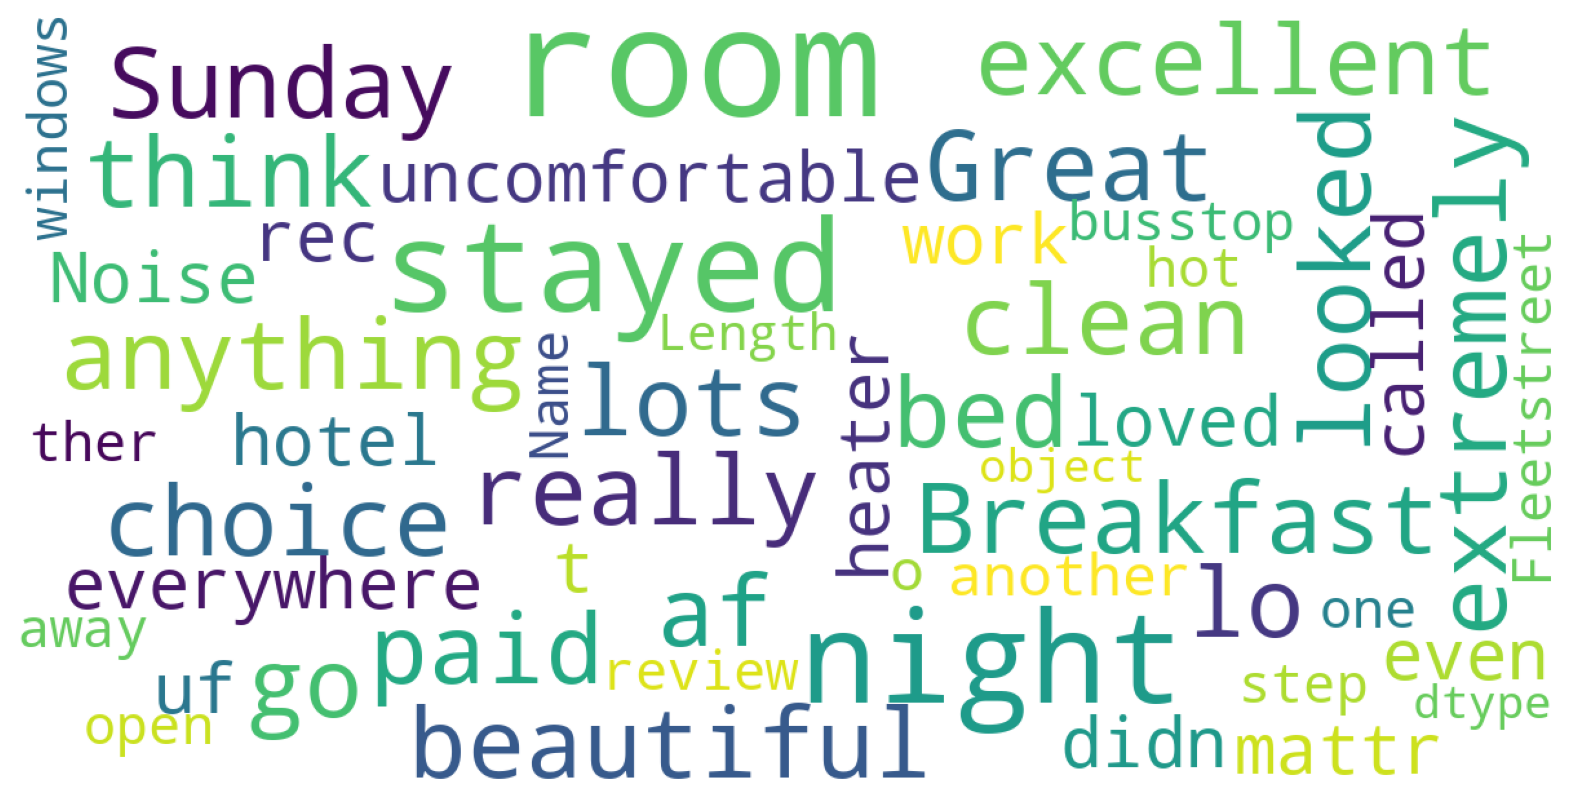

In [ ]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

# print wordcloud
show_wordcloud(reviews_df["review"])

In [ ]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >=5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
1395,Brilliant hotel perfect location,0.789
755,Lovely comfortable beds pillows,0.780
1869,Friendly staff good location great room,0.773
1427,great value for money,0.765
3619,Friendly and helpful staff delicious breakfas...,0.718
3624,late checkout easily granted Good bathroom,0.709
1412,Nice modern premises friendly staff good gym,0.690
3437,Comfortable stay and pleasant staff,0.688
893,great place good stuff lovely hotel in general,0.684
1509,Great location Great staff Very comfy Very go...,0.672


In [ ]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
3113,Nothing Great little hotel,0.523
3831,it s such a terrible experience,0.508
2778,The experience was very bad staff unprofessio...,0.470
1647,Nothing Friendly staff good qualty for a reas...,0.456
2936,The room was appalling,0.455
759,Small room broken tv Location,0.437
1556,Nothing Excellent location for Covent Garden,0.375
3633,Fire alarm at 8am Staff welcoming and friendly,0.322
1620,Nothing Great breakfasts and very nice people,0.289
4139,Not very clean and rooms not really looked af...,0.287


<ipython-input-30-78be2137db92>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['compound'], hist = False, label = label)
<ipython-input-30-78be2137db92>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['compound'], hist = False, label = label)


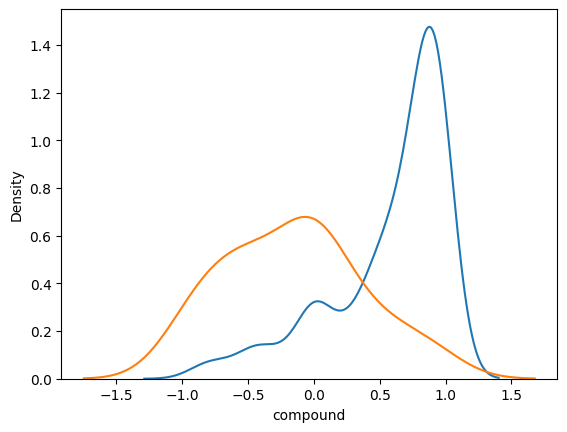

In [ ]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]

    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

In [ ]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

In [ ]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.159751
8,doc2vec_vector_2,0.103474
10,doc2vec_vector_4,0.101576
2,pos,0.099980
9,doc2vec_vector_3,0.096166
6,doc2vec_vector_0,0.090227
7,doc2vec_vector_1,0.085970
1,neu,0.075376
0,neg,0.068849
5,nb_words,0.060711


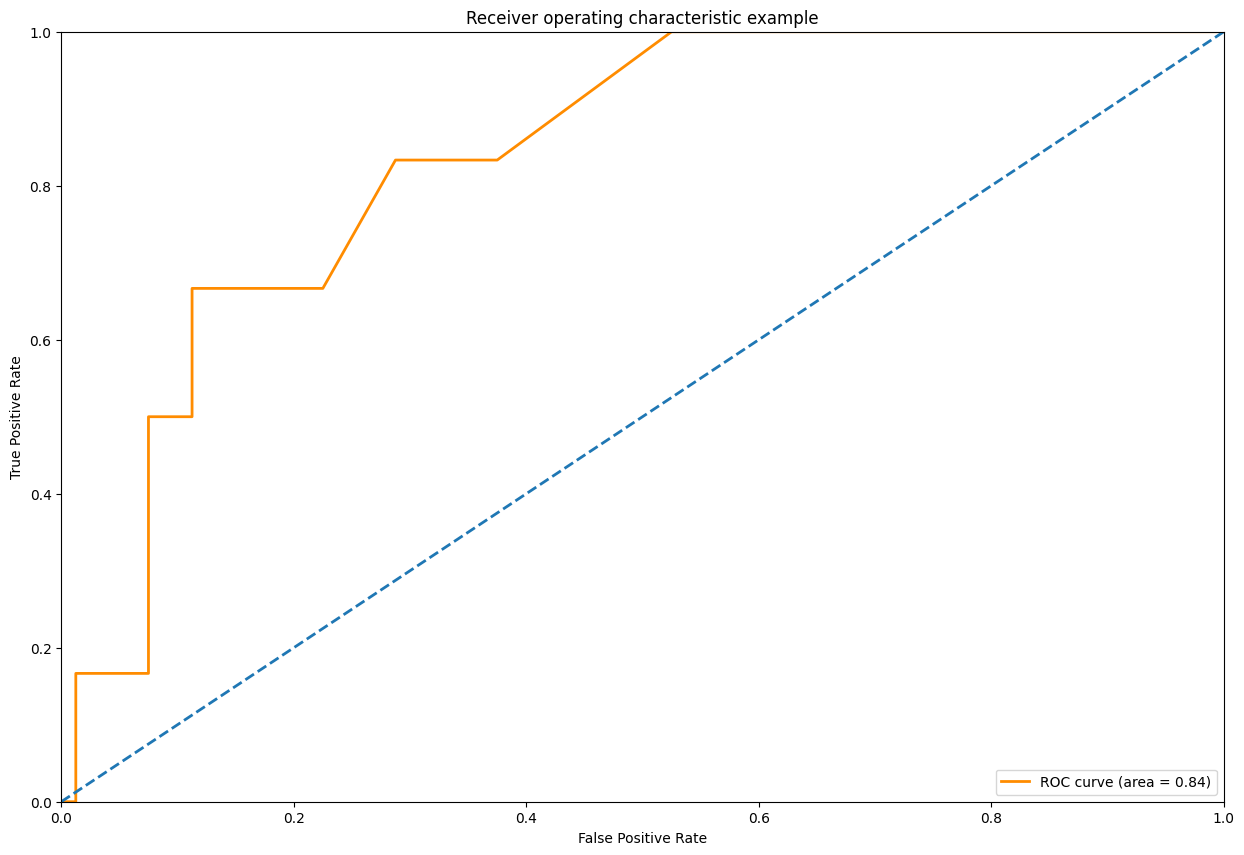

In [ ]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
!apt-get -qq install -y libarchive-dev && pip install -U libarchive

!apt-get -qq install -y graphviz && pip install pydot

!pip install cartopy

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.28')

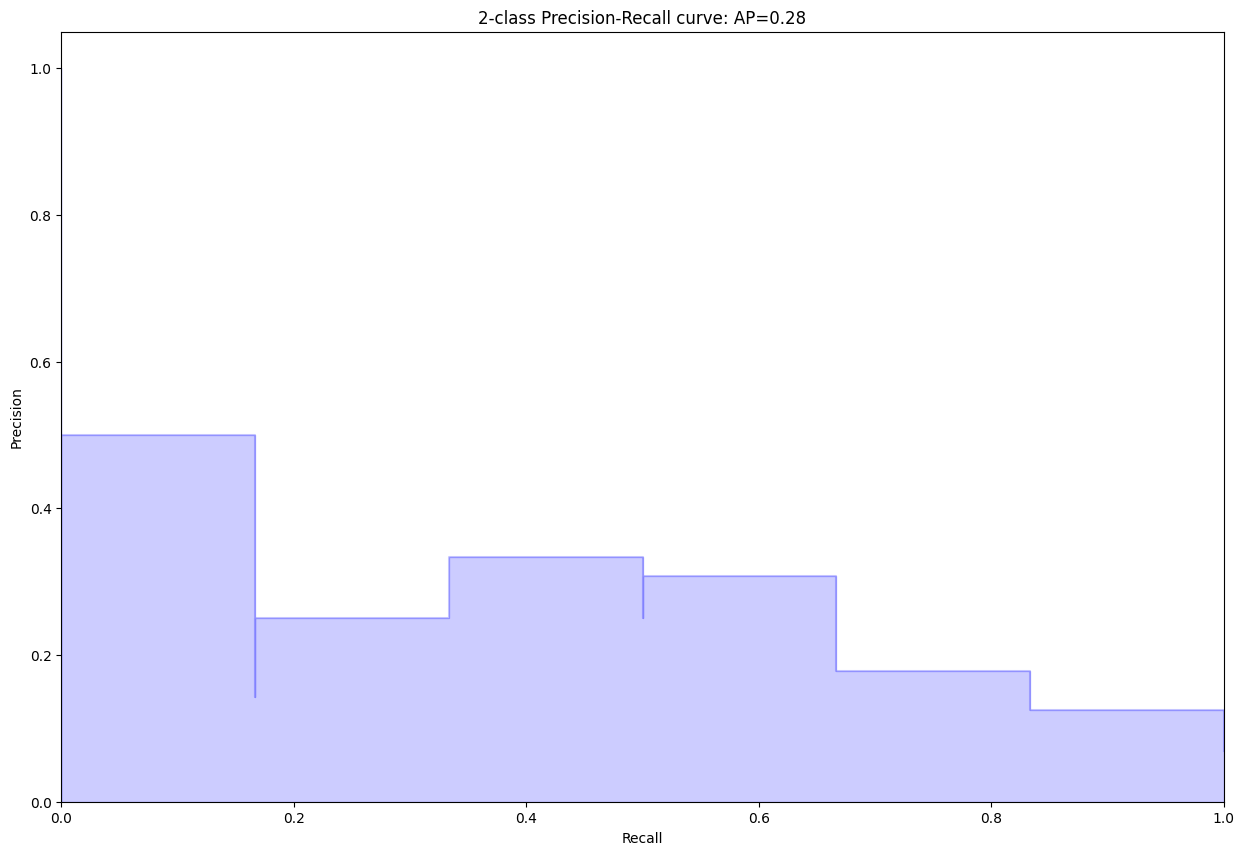

In [ ]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
try:
    from inspect import signature
except ImportError:
    from ..externals.funcsigs import signature


average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))